# Assignment 2, Exercise 3: (PSO vs K-means)

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from timeit import default_timer as timer

We start by creating a data set for testing:

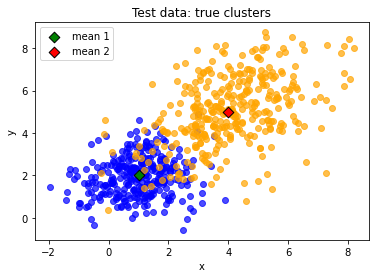

In [2]:
rng = rnd.default_rng(42)


mean1 = [1, 2]
mean2 = [4, 5]

cluster1 = rng.multivariate_normal(mean1, [[1, 0], [0, 1]], size = 300)
cluster2 = rng.multivariate_normal(mean2, [[2, 1], [1, 3]], size = 350)

plt.title('Test data: true clusters')
plt.xlabel('x')
plt.ylabel('y')

plt.scatter(cluster1[:,0], cluster1[:,1], alpha = .7, color = 'b')
plt.scatter(cluster2[:,0], cluster2[:,1], alpha = .7, color = 'orange')
plt.scatter(mean1[0], mean1[1], s = 57, label = 'mean 1', color = 'g', \
            edgecolor = 'black', marker = 'D')
plt.scatter(mean2[0], mean2[1], s = 57, label = 'mean 2', color = 'r', \
            edgecolor = 'black', marker = 'D')
plt.legend()
plt.show()


test_data = np.append(cluster1, cluster2, axis = 0)

**(a):**

In [3]:
def PSOclustering(numb_clusters, data, swarm_size, maxiter, crit, rng = rnd.default_rng(),
                  omega = 0.7298, alpha1 = 1.49618, alpha2 = 1.49618, \
                  plot = False, time_limit = 'inf', print_time = False):
          # start timer:
    start = timer()
          # we assume our data is shaped as [datapoint_i]_i:
    data_dim = np.shape(data)[1]
    data_size = np.shape(data)[0]
    
    
    swarm = np.zeros((swarm_size, numb_clusters, data_dim), dtype = float)

    for idx in range(swarm_size):
        swarm[idx] = data[rng.choice(np.arange(data_size), \
                                     size = numb_clusters, replace = False)]

          # distances to clusters:
    distances = np.zeros((swarm_size, data_size, numb_clusters), dtype = float)
    
    fitness = np.zeros((maxiter, swarm_size), dtype = float)
    
    local_opt = np.copy(swarm)
    global_opt = np.zeros((numb_clusters, data_dim))
    
    velocity = np.zeros((swarm_size, numb_clusters, data_dim))
    stopped_at = maxiter
    
    hist_global_opt = np.zeros((maxiter, numb_clusters, data_dim))
    global_fit = np.zeros(maxiter)
    
    # ----------------------The algorithm-------------------------------
    for idx in range(maxiter):
        if time_limit != 'inf' and timer() - start >= time_limit:
            stopped_at = idx
            break
        
        for idy, centroids in enumerate(swarm):
            for idz in range(numb_clusters):
          # array of distances from each dapa point to centroid:
                distances[idy, :, idz] = np.linalg.norm(data - centroids[idz], axis = 1)
                
          # array informing what to what centroid each datapoint is closest
            assign_to_clust = np.argmin(distances[idy], axis = 1)
            
          # calculating the new centroids:
            summation = 0
            for idz in range(numb_clusters):
                if np.sum(assign_to_clust == idz) != 0:
                    summation += np.sum(np.linalg.norm(data[np.where(\
                                                    assign_to_clust == idz)] \
                                - centroids[idz], axis = 1), axis = 0) \
                                / np.sum(assign_to_clust == idz)
                else:
                    summation = np.inf
            fitness[idx, idy] = summation / numb_clusters
        
            if idx > 0 and fitness[idx, idy] < fitness[idx - 1, idy]:
                local_opt[idy, :] = centroids

        coords = np.unravel_index(np.argmin(fitness[:idx + 1]), fitness[:idx + 1].shape)
        
          # new global max:
        if coords[0] == idx:
            global_opt = local_opt[coords[1]]

        for idy in range(swarm_size):
            velocity[idy] = velocity[idy] * omega \
                + alpha1 * np.multiply(rnd.uniform(size = (numb_clusters, data_dim)),\
                                                       (local_opt[idy] - swarm[idy]))\
                + alpha2 * np.multiply(rnd.uniform(size = (numb_clusters, data_dim)),\
                                                        (global_opt - swarm[idy]))
            swarm[idy] += velocity[idy]
            
        hist_global_opt[idx] = global_opt
        global_fit[idx] = fitness[coords]
        
        if idx > 0 and not np.any(np.logical_or(np.Inf == fitness[idx], \
                                                np.Inf == fitness[idx - 1])) \
                and np.sum(np.abs(fitness[idx] - fitness[idx - 1])) < crit:
            stopped_at = idx
            print('crit achived after', idx, 'steps.')
            break
    # ------------------------End------------------------------------
        # Will contain the clusters we will return:        
    data_lst = [np.array([],dtype = object)] * numb_clusters
                
          # array informing what to what centroid each datapoint is closest
    assign_to_clust = np.argmin(distances[coords[1]], axis = 1)
    
          # Assigning data to each cluster:
    for idx in range(numb_clusters):
        data_lst[idx] = data[np.where(assign_to_clust == idx)]
        
    if plot:
        plt.title('Fitness of each particle')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness')
        plt.plot(np.arange(stopped_at), fitness[:stopped_at])
        plt.yscale('log')
        plt.show()
        
        plt.title('Best fitness')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness')
        plt.plot(np.arange(stopped_at), global_fit[:stopped_at])
        plt.show()
        
        if data_dim == 2:
            plt.title('Optimum centroid movement')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.scatter(data[:,0], data[:,1], alpha = .25, color = 'yellow', zorder = 0)
            plt.plot(hist_global_opt[:stopped_at - 1, 0, 0], \
                     hist_global_opt[:stopped_at - 1, 0, 1], color = 'b', zorder = 1)
            plt.scatter(hist_global_opt[stopped_at - 1, 0, 0], \
                        hist_global_opt[stopped_at - 1, 0, 1], color = 'b', \
                        edgecolor = 'black', marker = 'D', label = 'final position blue', \
                        zorder = 2)
            plt.plot(hist_global_opt[:stopped_at - 1, 1, 0], \
                     hist_global_opt[:stopped_at - 1, 1, 1], color = 'r', zorder = 1)
            plt.scatter(hist_global_opt[stopped_at - 1, 1, 0], \
                        hist_global_opt[stopped_at - 1, 1, 1], color = 'r', \
                        edgecolor = 'black', marker = 'D', label = 'final position red', \
                        zorder = 2)
            

            plt.show()
        
    if print_time:
        print('Time taken:', timer() - start, 'seconds')
        
    return global_opt, data_lst, global_fit[stopped_at - 1]

Testing the def PSOclustering algorithm:

crit achived after 181 steps.


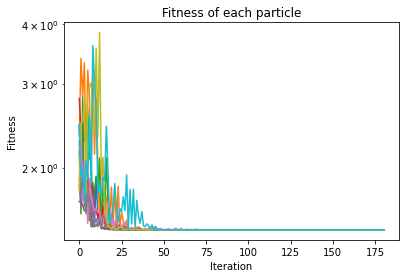

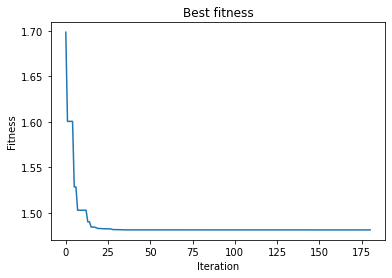

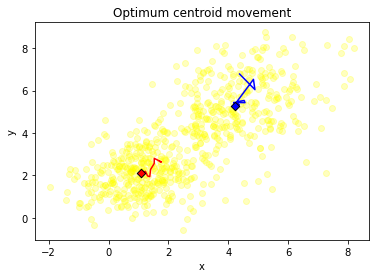

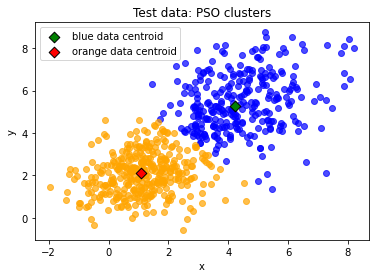

In [4]:
means, clusters, _ = PSOclustering(2, test_data, 10, 5000, 1e-8, time_limit = 20, plot = True)

plt.title('Test data: PSO clusters')
plt.xlabel('x')
plt.ylabel('y')

plt.scatter(clusters[0][:,0], clusters[0][:,1], alpha = .7, color = 'b')
plt.scatter(clusters[1][:,0], clusters[1][:,1], alpha = .7, color = 'orange')
plt.scatter(means[0][0], means[0][1], s = 57, label = 'blue data centroid', \
            color = 'g', edgecolor = 'black', marker = 'D')
plt.scatter(means[1][0], means[1][1], s = 57, label = 'orange data centroid', \
            color = 'r', edgecolor = 'black', marker = 'D')
plt.legend()
plt.show()

**(b):**

In [5]:
def kmeans(numb_clusters, data, maxiter, crit,
           omega = .7, alpha1 = 1, alpha2 = 1, rng = rnd.default_rng()):
    
      # we assume our data is shaped as [datapoint_i]_i:
    data_dim = np.shape(data)[1]
    data_size = np.shape(data)[0]

    current_clusters = data[rng.choice(np.arange(data_size), \
                                     size = numb_clusters, replace = False)]
    
      # distances to clusters:
    distances = np.zeros((data_size, numb_clusters), dtype = float)
    
      # binary array, assigning datapoints to a cluster:
    assign_to_clust = np.zeros_like(distances, dtype = float)
    #----------------------- the algorythm ----------------------
    for idx in range(maxiter):
        
          # creating an array with distances to each centroid
        for idy in range(numb_clusters):
            distances[:, idy] = np.linalg.norm(data - current_clusters[idy], axis = 1)
        
          # array informing what to what centroid each datapoint is closest
        assign_to_clust = np.argmin(distances, axis = 1)
    
        temp_clusters = np.copy(current_clusters)
          # calculating the new centroids:
        for idy in range(numb_clusters):
          # no empty classes:
            if not np.any(assign_to_clust == idy):
                current_clusters[idy] = data[rng.choice(np.arange(data_size))]
            else:
                current_clusters[idy] = np.mean(data[np.where(assign_to_clust == idy)], \
                                                        axis = 0)
            
        if np.sum(np.abs(temp_clusters - current_clusters)) < crit:
            print('Crit achieved after', idx, 'steps.')
            break
    #------------------------- End ------------------------------        
          # Will contain the clusters we will return:        
    data_lst = [np.array([],dtype = object)] * numb_clusters

          # Assigning data to each cluster:
    for idx in range(numb_clusters):
        data_lst[idx] = data[np.where(assign_to_clust == idx)]
        
    summation = 0
    for idz in range(numb_clusters):
        if np.sum(assign_to_clust == idz) != 0:
            summation += np.sum(np.linalg.norm(data[np.where(assign_to_clust == idz)] \
                        - current_clusters[idz], axis = 1), axis = 0) \
                        / np.sum(assign_to_clust == idz)
        else:
            summation = np.inf
    fitness = summation / numb_clusters
        
    return current_clusters, data_lst, fitness

Testing the K-means algorithm:

Crit achieved after 10 steps.


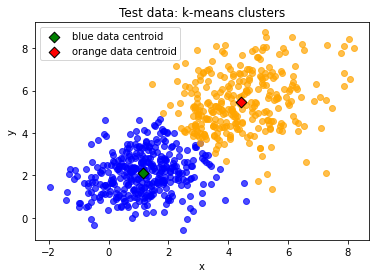

In [6]:
means, clusters, _ = kmeans(2, test_data, 25, 1e-8)

plt.title('Test data: k-means clusters')
plt.xlabel('x')
plt.ylabel('y')

plt.scatter(clusters[0][:,0], clusters[0][:,1], alpha = .7, color = 'b')
plt.scatter(clusters[1][:,0], clusters[1][:,1], alpha = .7, color = 'orange')
plt.scatter(means[0][0], means[0][1], s = 57, label = 'blue data centroid', \
            color = 'g', edgecolor = 'black', marker = 'D')
plt.scatter(means[1][0], means[1][1], s = 57, label = 'orange data centroid', \
            color = 'r', edgecolor = 'black', marker = 'D')
plt.legend()
plt.show()



**(c):**

Creating data:

In [7]:
uniform_data = rng.uniform(-1, 1, size = (400, 2))

Assigning data to clusters: <br>
(note that the axeses are different from in the article)

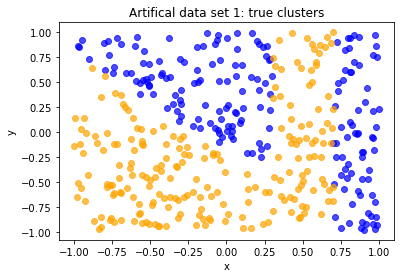

In [8]:
def assign(data_point):
    assert np.size(data_point) == 2
    return data_point[0] >= 0.7 or \
               (data_point[0] <= .3 and data_point[1] >= -1/5 - data_point[0])

artificial_clusters = [assign(data_point) for data_point in uniform_data]
ads_cluster1 = uniform_data[artificial_clusters]
ads_cluster2 = uniform_data[np.logical_not(artificial_clusters)]
ads_all = np.vstack((ads_cluster1, ads_cluster2))

plt.title('Artifical data set 1: true clusters')
plt.xlabel('x')
plt.ylabel('y')

plt.scatter(ads_cluster1[:,0], ads_cluster1[:,1], alpha = .7, color = 'b')
plt.scatter(ads_cluster2[:,0], ads_cluster2[:,1], alpha = .7, color = 'orange')
plt.show()


**(d):**

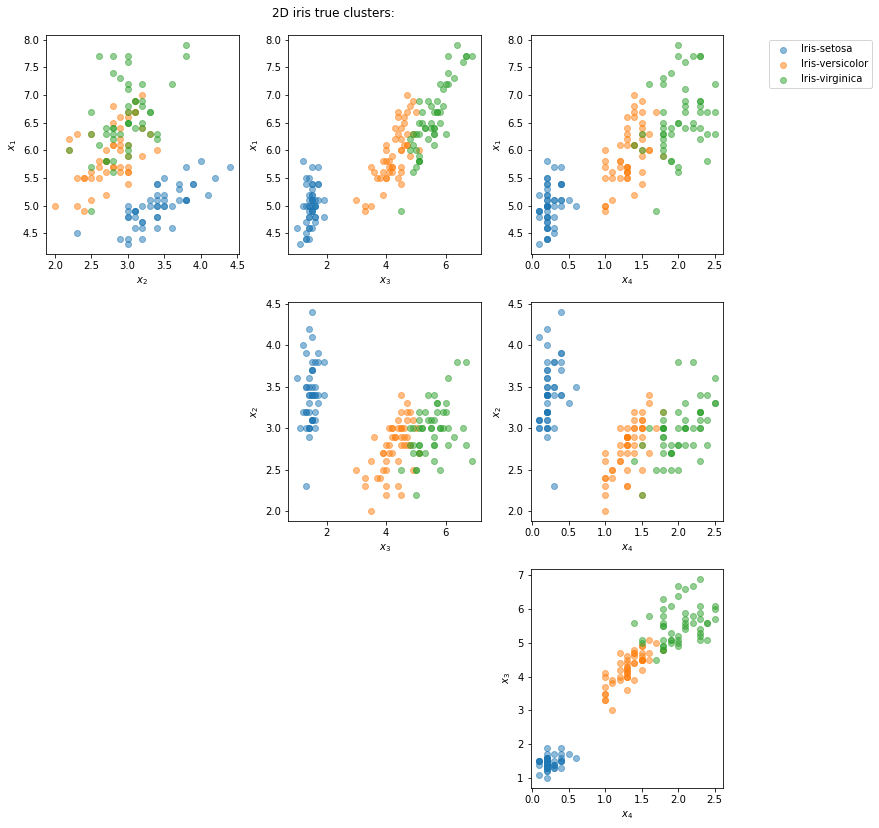

In [9]:
import pandas as pd

iris_data_dict = pd.read_csv("iris.data")
iris_data_arr_classes = np.array(iris_data_dict.iloc[:, :5])
iris_data = np.array(iris_data_arr_classes[:, :4], dtype = float)
isis_class_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

iris_class1 = iris_data[iris_data_arr_classes[:, 4] == isis_class_names[0]]
iris_class2 = iris_data[iris_data_arr_classes[:, 4] == isis_class_names[1]]
iris_class3 = iris_data[iris_data_arr_classes[:, 4] == isis_class_names[2]]

fig = plt.figure(figsize=(15,15)) 
fig.suptitle('2D iris true clusters:\n')  
for i in range(4):
    for j in range(4):
        if i > j:
            plt.subplot(4, 4, i + 4 * j + 1)
            plt.tight_layout()
            plt.scatter(iris_class1[:, i], iris_class1[:, j], \
                        alpha = .5, label = isis_class_names[0])
            plt.scatter(iris_class2[:, i], iris_class2[:, j], \
                        alpha = .5, label = isis_class_names[1])
            plt.scatter(iris_class3[:, i], iris_class3[:, j], \
                        alpha = .5, label = isis_class_names[2])
            plt.xlabel("$x_" + str(i + 1) + '$')
            plt.ylabel("$x_" + str(j + 1) + '$')  
            if i == 3 and j == 0:
                plt.legend(bbox_to_anchor=(1.8, 1.0), loc = 'upper right')
plt.show()

In [10]:
def perform_tests(trials, iterations, data_set, clusters):
    pso_fitness_arr = np.zeros(trials, dtype = float)
    for idx in range(trials):
        _, _, pso_fitness = PSOclustering(clusters, data_set, 10, 100, 0)
        pso_fitness_arr[idx] = pso_fitness
    
    kmeans_fitness_arr = np.zeros(trials, dtype = float)
    for idx in range(trials):
        best_fitness = -1
        for idy in range(10):
            _, _, kmeans_fitness = kmeans(clusters, data_set, 100, 0)
            best_fitness = max(kmeans_fitness, best_fitness)
        kmeans_fitness_arr[idx] = best_fitness
    return pso_fitness_arr, kmeans_fitness_arr

def print_result(fitnesses, title):
    fitness = np.nan_to_num(fitnesses)
    plt.title(title)
    plt.hist(fitnesses)
    plt.show()
    print('Fitness: ' + str(round(np.mean(fitnesses), 4)) + \
          ' +/- ' + str(round(np.std(fitnesses), 4)))


Performing the tests:

In [11]:
ads_pso_fitness_arr, ads_kmeans_fitness_arr = perform_tests(30, 100, ads_all, 2)
iris_pso_fitness_arr, iris_kmeans_fitness_arr = perform_tests(30, 100, iris_data, 3)

Artificial data set results:

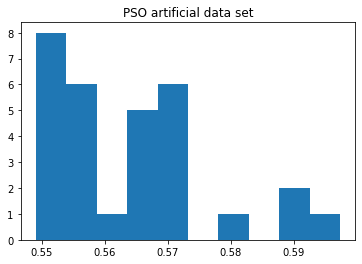

Fitness: 0.5637 +/- 0.0127


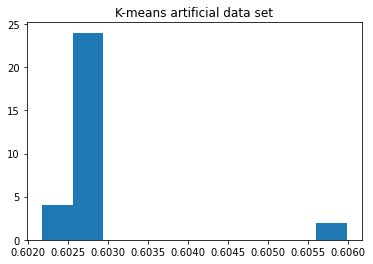

Fitness: 0.6029 +/- 0.0008


In [12]:
print_result(ads_pso_fitness_arr, 'PSO artificial data set')
print_result(ads_kmeans_fitness_arr, 'K-means artificial data set')

Iris data set results:

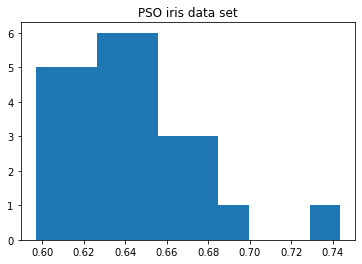

Fitness: 0.6404 +/- 0.0323


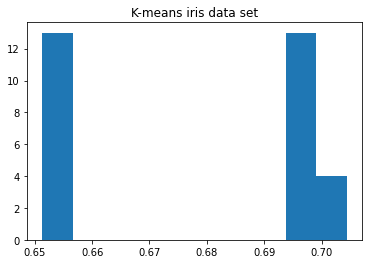

Fitness: 0.6787 +/- 0.024


In [13]:
print_result(iris_pso_fitness_arr, 'PSO iris data set')
print_result(iris_kmeans_fitness_arr, 'K-means iris data set')

**(e):** <br>
Comparing PSO and K-means on the artificial data set:

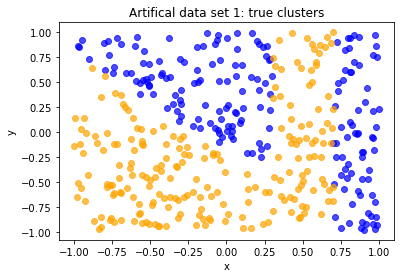

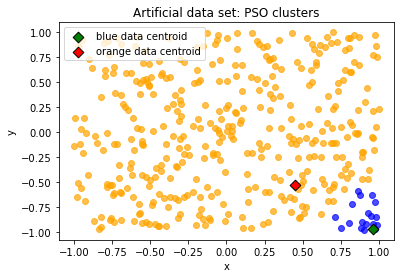

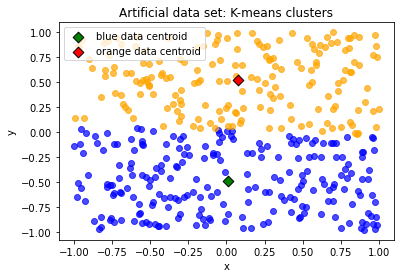

In [14]:
plt.title('Artifical data set 1: true clusters')
plt.xlabel('x')
plt.ylabel('y')

plt.scatter(ads_cluster1[:,0], ads_cluster1[:,1], alpha = .7, color = 'b')
plt.scatter(ads_cluster2[:,0], ads_cluster2[:,1], alpha = .7, color = 'orange')
plt.show()

means, clusters, _ = PSOclustering(2, ads_all, 10, 100, 0)
plt.title('Artificial data set: PSO clusters')
plt.xlabel('x')
plt.ylabel('y')

plt.scatter(clusters[0][:,0], clusters[0][:,1], alpha = .7, color = 'b')
plt.scatter(clusters[1][:,0], clusters[1][:,1], alpha = .7, color = 'orange')
plt.scatter(means[0][0], means[0][1], s = 57, label = 'blue data centroid', \
            color = 'g', edgecolor = 'black', marker = 'D')
plt.scatter(means[1][0], means[1][1], s = 57, label = 'orange data centroid', \
            color = 'r', edgecolor = 'black', marker = 'D')
plt.legend()
plt.show()



best_fitness = 0
for _ in range(10):
    temp_means, temp_clusters, fitness = kmeans(2, ads_all, 100, 0)
    if best_fitness < fitness:
        means = temp_means
        clusters = temp_clusters
plt.title('Artificial data set: K-means clusters')
plt.xlabel('x')
plt.ylabel('y')

plt.scatter(clusters[0][:,0], clusters[0][:,1], alpha = .7, color = 'b')
plt.scatter(clusters[1][:,0], clusters[1][:,1], alpha = .7, color = 'orange')
plt.scatter(means[0][0], means[0][1], s = 57, label = 'blue data centroid', \
            color = 'g', edgecolor = 'black', marker = 'D')
plt.scatter(means[1][0], means[1][1], s = 57, label = 'orange data centroid', \
            color = 'r', edgecolor = 'black', marker = 'D')
plt.legend()
plt.show()

Comparing PSO and K-means on the iris data set:

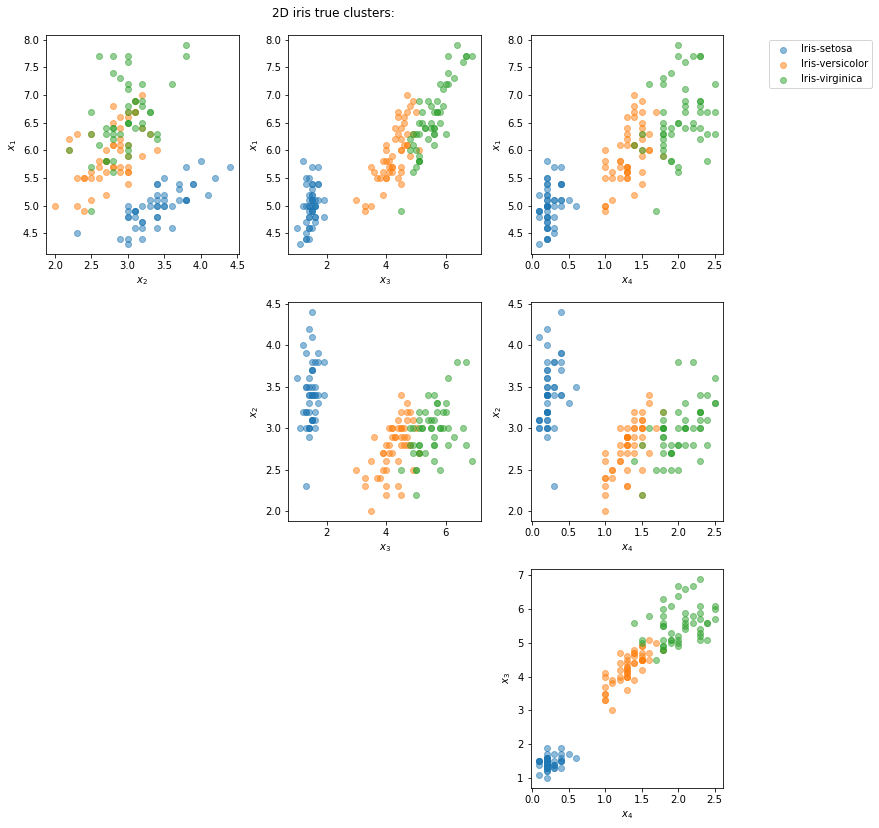

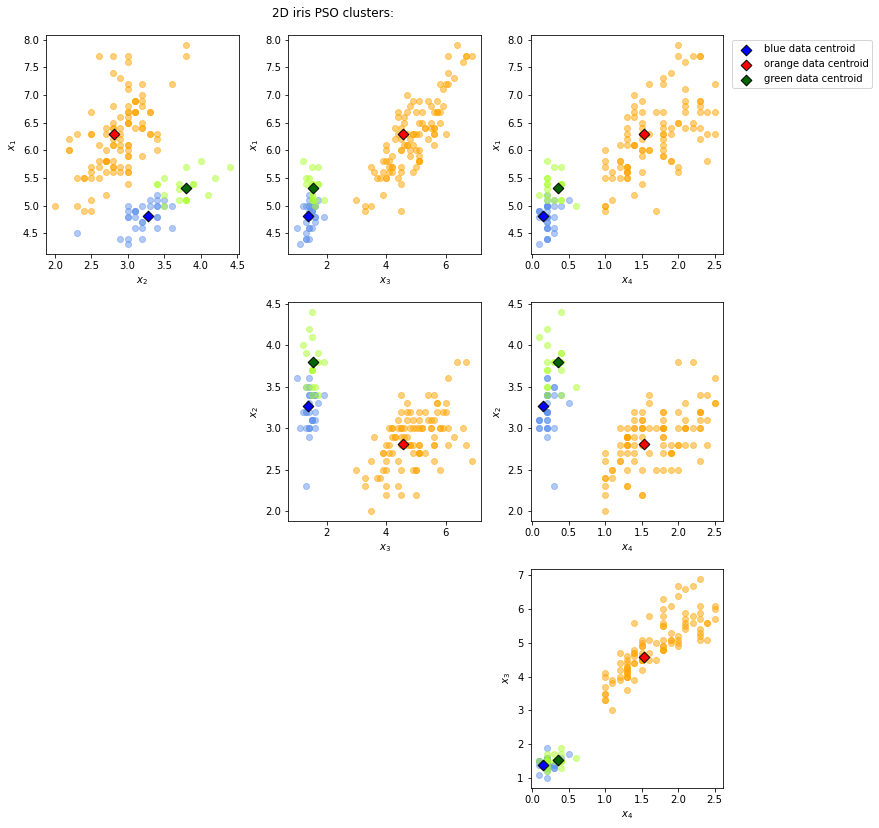

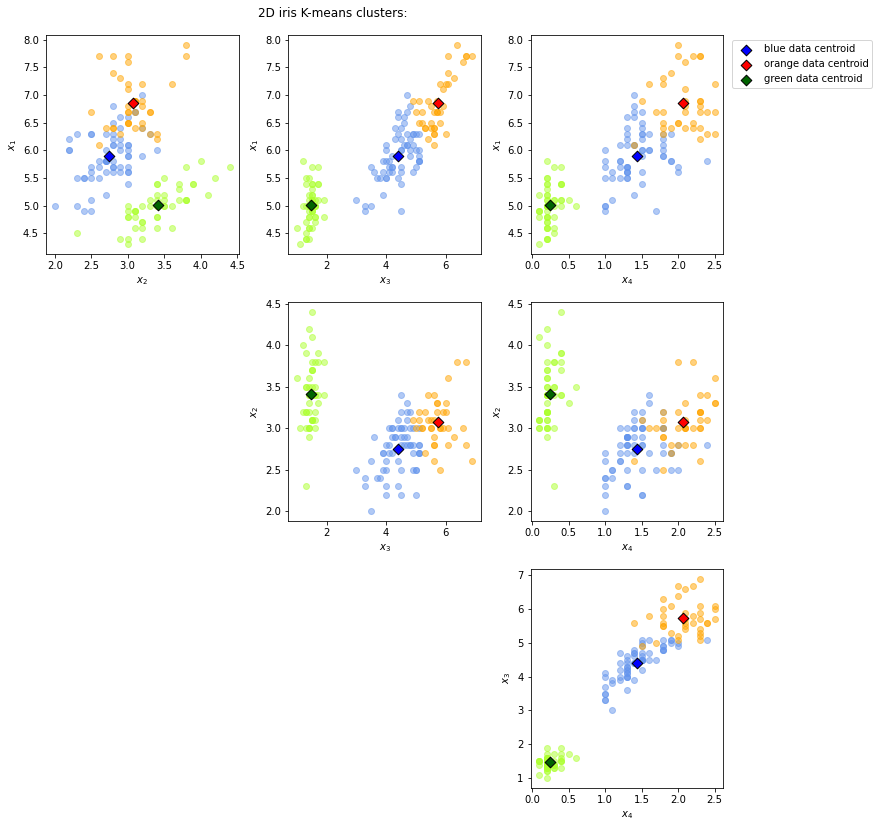

In [15]:
fig = plt.figure(figsize=(15,15)) 
fig.suptitle('2D iris true clusters:\n')  
for i in range(4):
    for j in range(4):
        if i > j:
            plt.subplot(4, 4, i + 4 * j + 1)
            plt.tight_layout()
            plt.scatter(iris_class1[:, i], iris_class1[:, j], \
                        alpha = .5, label = isis_class_names[0])
            plt.scatter(iris_class2[:, i], iris_class2[:, j], \
                        alpha = .5, label = isis_class_names[1])
            plt.scatter(iris_class3[:, i], iris_class3[:, j], \
                        alpha = .5, label = isis_class_names[2])
            plt.xlabel("$x_" + str(i + 1) + '$')
            plt.ylabel("$x_" + str(j + 1) + '$')  
            if i == 3 and j == 0:
                plt.legend(bbox_to_anchor=(1.8, 1.0), loc = 'upper right')
plt.show()

means, clusters, _ = PSOclustering(3, iris_data, 10, 100, 0)
fig = plt.figure(figsize=(15,15)) 
fig.suptitle('2D iris PSO clusters:\n')  
for i in range(4):
    for j in range(4):
        if i > j:
            plt.subplot(4, 4, i + 4 * j + 1)
            plt.tight_layout()
            plt.scatter(clusters[0][:, i], clusters[0][:, j], \
                        alpha = .5, color = 'cornflowerblue')
            plt.scatter(clusters[1][:, i], clusters[1][:, j], \
                        alpha = .5, color = 'orange')
            plt.scatter(clusters[2][:, i], clusters[2][:, j], \
                        alpha = .5, color = 'greenyellow')
            
            plt.scatter(means[0,i], means[0,j], s = 57, label = 'blue data centroid', \
            color = 'blue', edgecolor = 'black', marker = 'D')            
            plt.scatter(means[1,i], means[1,j], s = 57, label = 'orange data centroid', \
            color = 'red', edgecolor = 'black', marker = 'D')
            plt.scatter(means[2,i], means[2,j], s = 57, label = 'green data centroid', \
            color = 'darkgreen', edgecolor = 'black', marker = 'D')
            
            plt.xlabel("$x_" + str(i + 1) + '$')
            plt.ylabel("$x_" + str(j + 1) + '$')
            if i == 3 and j == 0:
                plt.legend(bbox_to_anchor=(1.8, 1.0), loc = 'upper right')
plt.show()


best_fitness = 0
for _ in range(10):
    temp_means, temp_clusters, fitness = kmeans(3, iris_data, 100, 0)
    if best_fitness < fitness:
        means = temp_means
        clusters = temp_clusters

fig = plt.figure(figsize=(15,15)) 
fig.suptitle('2D iris K-means clusters:\n')  
for i in range(4):
    for j in range(4):
        if i > j:
            plt.subplot(4, 4, i + 4 * j + 1)
            plt.tight_layout()
            plt.scatter(clusters[0][:, i], clusters[0][:, j], \
                        alpha = .5, color = 'cornflowerblue')
            plt.scatter(clusters[1][:, i], clusters[1][:, j], \
                        alpha = .5, color = 'orange')
            plt.scatter(clusters[2][:, i], clusters[2][:, j], \
                        alpha = .5, color = 'greenyellow')
            
            plt.scatter(means[0,i], means[0,j], s = 57, label = 'blue data centroid', \
            color = 'blue', edgecolor = 'black', marker = 'D')            
            plt.scatter(means[1,i], means[1,j], s = 57, label = 'orange data centroid', \
            color = 'red', edgecolor = 'black', marker = 'D')
            plt.scatter(means[2,i], means[2,j], s = 57, label = 'green data centroid', \
            color = 'darkgreen', edgecolor = 'black', marker = 'D')
            
            plt.xlabel("$x_" + str(i + 1) + '$')
            plt.ylabel("$x_" + str(j + 1) + '$')
            if i == 3 and j == 0:
                plt.legend(bbox_to_anchor=(1.8, 1.0), loc = 'upper right')
plt.show()

**Conclusion:** <br>
We see from the histograms and mean values from part **(d)**, that for both the artificial dataset and the iris data set, the PSO clustering algorithm achieves a lower fitness, which is good, as in this case the fitness is equal to the quantization error, which we want to be low.
We do also see that the PSO algorithm has a higher varience in it's fitness between runs. <br>
When looking at the actual clusters found in part **(e)**, we note the following:<br>
For the artificial data set there is no structure (the data is uniformly distributed), and the true classes are meaningless for the performance of the algorithm and for the eventual fitness. It can then not be expected that the 'true' classes are found by either algorithm. <br>
By viewing multiple runs of the algorithms we see that $K$-means usually cuts the data set through the middle, either vertically of harizontally, whereas PSO has more varience in how it devides the data.
This can be seen as desiarable, as it reflects the structurelessness of the data better. <br>
For the iris data set we see that the $K$-means algorithm finds classes with the same structure of that of the true classes.
For the PSO algorithm this is not the case, as the classes 'Iris-versicolor' and 'Iris-virginica' are merged into one class.
For some runs the PSO algorithm does split these classes correctly, but usually they are merged.